In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your CSV file
file_path = '/content/drive/My Drive/IMDB data/IMDB Dataset.csv'

# Read CSV file into DataFrame
df = pd.read_csv(file_path)

df['sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)

Mounted at /content/drive


In [ ]:
# Load your dataset into a pandas DataFrame and preprocess it

# Tokenize the text
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
encoded_data = tokenizer.batch_encode_plus(
    df['review'],
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# Create TensorDataset
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['sentiment'])

dataset = TensorDataset(input_ids, attention_masks, labels)

# Split the dataset into training, validation, and testing sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoader
batch_size = 15
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Load pre-trained RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    n = 1
    for batch in train_dataloader:
        n += 1
        print(n)
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}")

In [ ]:
# Evaluation loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

val_accuracy = total_correct / total_samples
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9524


In [ ]:
# Testing loop
from sklearn.metrics import confusion_matrix, classification_report
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = total_correct / total_samples
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9492


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)


print("\nClassification Report:")
print(class_report)
print("Confusion Matrix:")
conf_matrix


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2482
           1       0.97      0.94      0.95      2518

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Confusion Matrix:


array([[2404,   78],
       [ 161, 2357]])

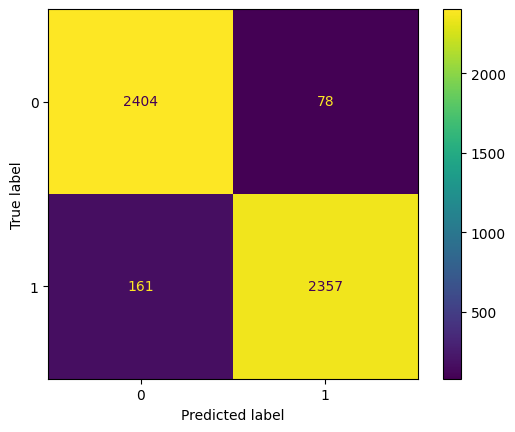

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()